# Snowplow Signals AI - Web Prospect Real-time Scoring Example


## Part 1: Use Case Definition

### Business Case
As a website owner we want to score prospect's ability to convert while on the website.

### User Journey
1. Prospects browse the marketing website.

2. They visit product and pricing pages, watch videos, etc.

3. In the end they achieve the main CTA - form submission.

### Prediction Point and Decisions

We want to score prospects (aka `domain_userid`s) live. This can be after each event, at the start of each `page_view`, or at some interval (e.g. every 10 seconds).

Once the score crosses `0.9` threshold - we'd like to engage them with a custom message.

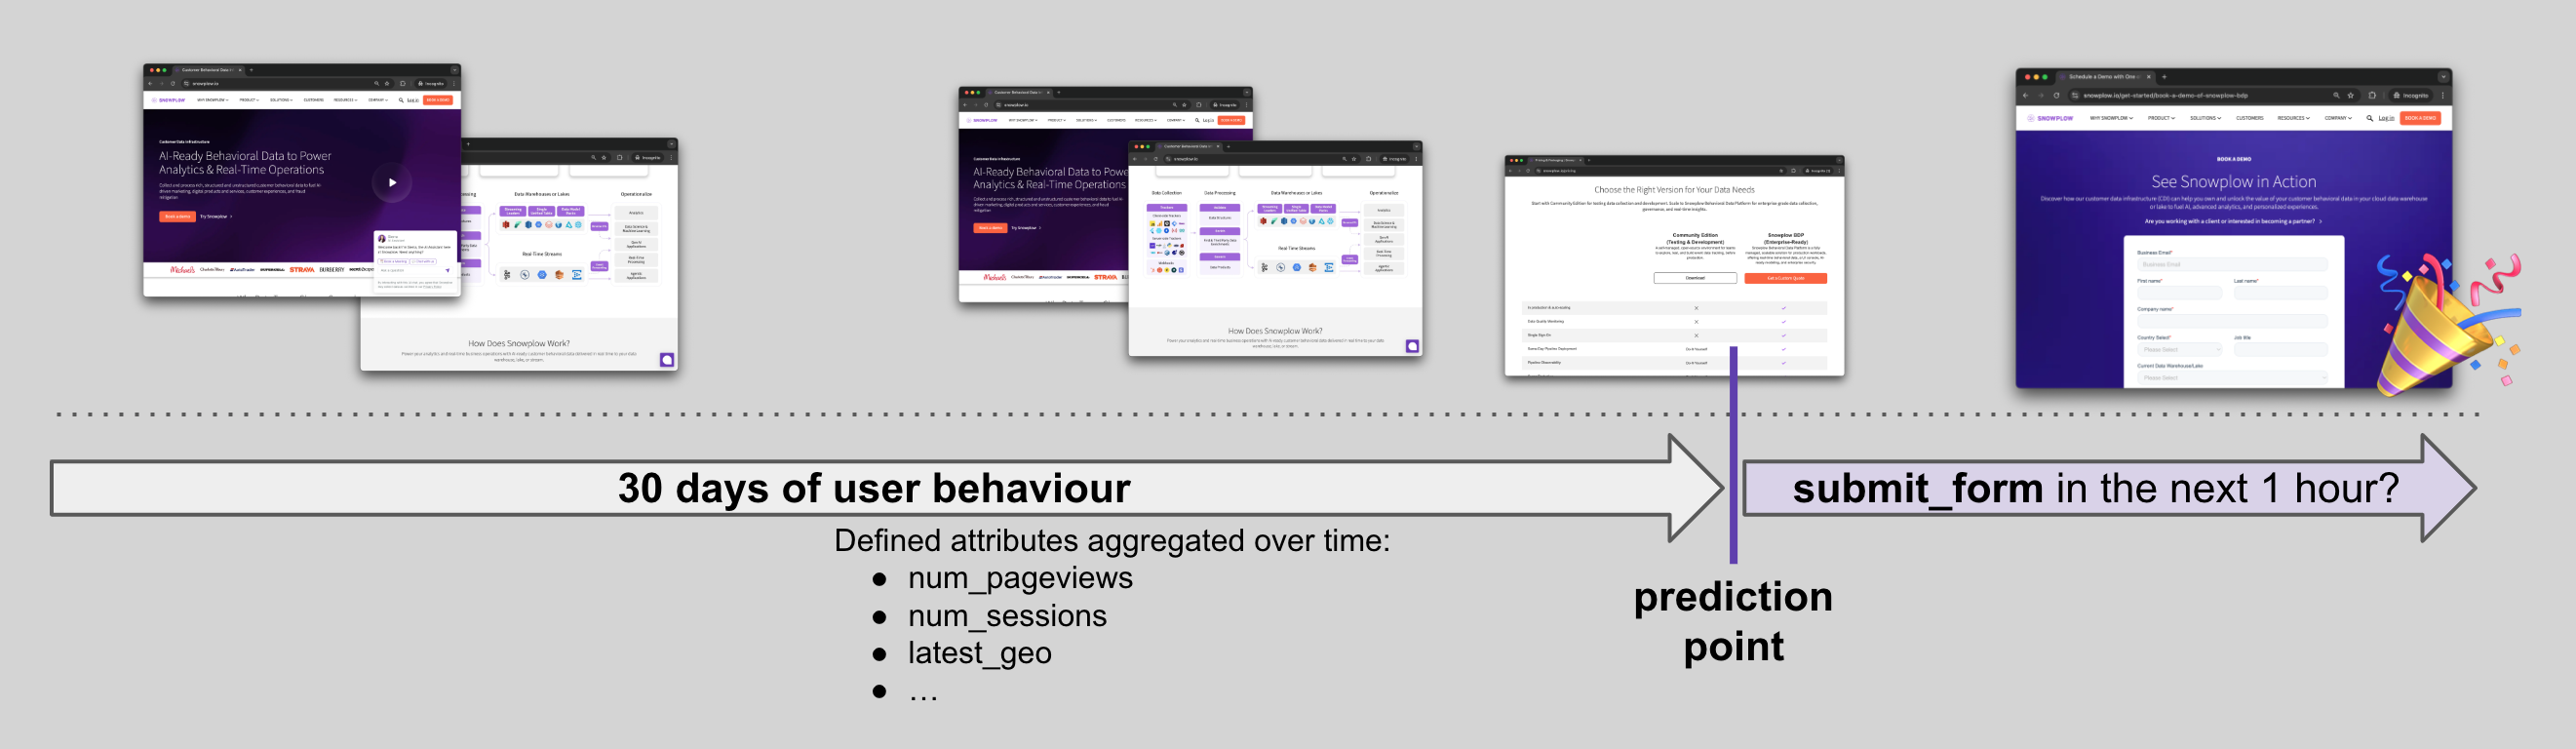

### High-Level Architecture

1. User browses the website. Snowplow behaviour events are collected in the background.
2. Behind the scenes, Snowplow Signals calculate user, session (or other entity) personalisation attributes in near real-time (e.g. `num_pageviews, num_sessions`, etc).
3. One can get these values back using Snowplow Signals SDK and use in a variety of ways.
4. Here we will train a model to predict likelyhood to convert on a landing page. And we will serve the model to perform some custom actions on the frontend.

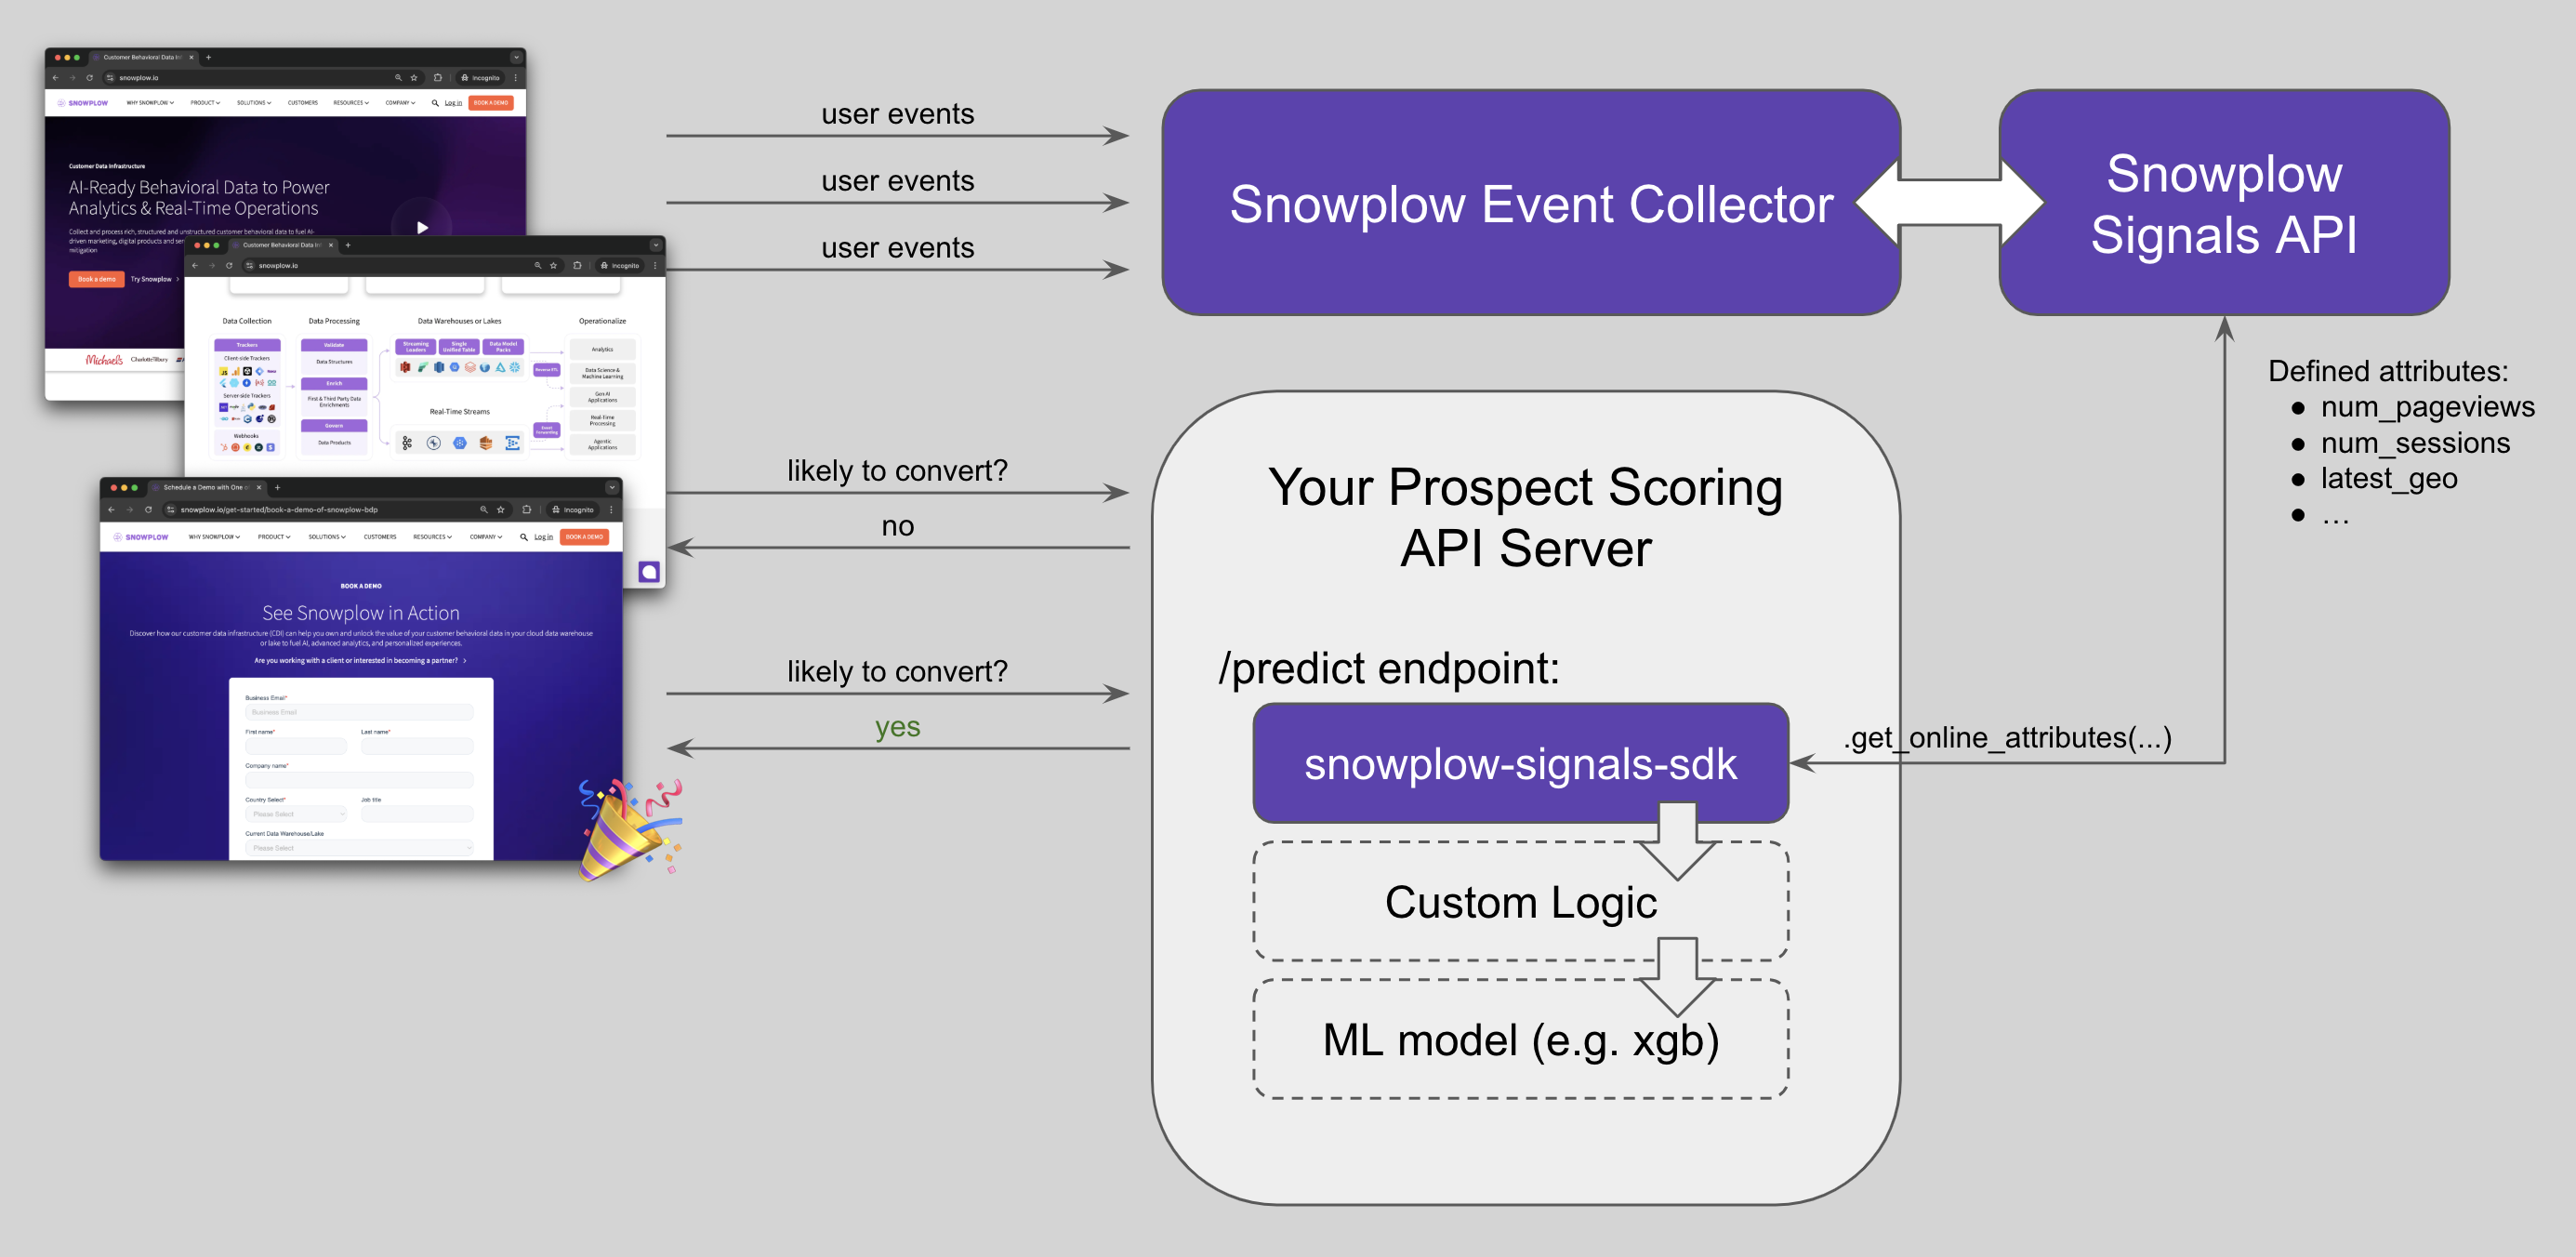

### Training Data

Let's say we decided to use the previous 30d of Snowplow raw event data for training.

After thorough research, ML team suggests we use these features:

Feature Name | Type | Description
-------------|------|-------------
`day_of_week` | int | current day of week
`latest_app_id` | string | current `app_id` value
`latest_device_class` | string | current YAUAA device class
`num_sessions_l7d/l30d` | int | number of unique sessions in the last 7/30 days
`num_apps_l7d/l30d` | int | number of unique `app_id`s engaged in the last 7/30 days
`num_page_views_l7d/l30d` | int | number of `page_view` events in the last 7/30 days
`num_page_pings_l7d/l30d` | int | number of `page_ping` events in the last 7/30 days, time on site
`num_pricing_views_l7d/l30d` | int | number of `page_view` events of the `/pricing` page in the last 7/30 days
`had_conversions_l7d/30d` | int | number of recent `submit_form` events in the last 7/30 days
`num_form_engagements_l7d` | int | number of recent for engagements, e.g.  `focus_form, change_form` events in the last 7 days
`num_media_events_l30d` | int | engagements with media events in the last 30 days
`first_refr_medium_l30d` | string | first referrer medium in the last 30 days
`first_mkt_medium_l30d` | string | first `utm_medium` in the last 30 days
`num_engaged_campaigns_l30d` | int | number of distinct engaged `utm_campaign`s in the last 30 days

### Configuration and Technical Details

1. We use Snowflake in this example to connect to the atomic table.
2. To deploy the real-time scoring API - we use ngrok to serve the model from this notebook to the outer world behind HTTPS.
3. Set your credentials for Snowflake, ngrok, Snowplow Signals in the Colab's Secrets (as on the screenshot below).
4. Update constants pointing to your Atomic table and Signals API endpoint.

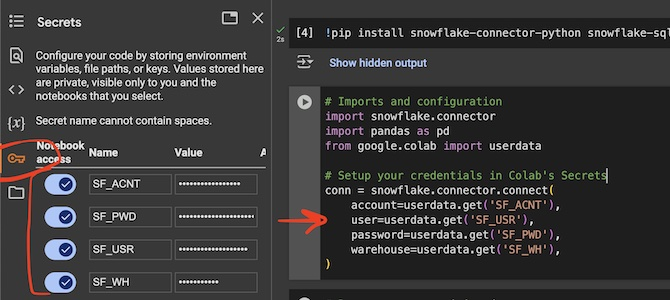

List of credential variables. 

Variable | Description
--- | ---
`SF_ACNT` | Snowflake Account
`SF_USR` | Snowflake User
`SF_PWD` | Snowflake Password
`SF_WH` | Snowflake Warehouse
`SP_API_KEY` | Snowplow Signals API Key
`SP_API_KEY_ID` | Snowplow Signals API ID
`SP_ORG_ID` | Snowplow Org ID
`NGROK_TOKEN` | ngrok Token

In [ ]:
!pip install snowflake-connector-python snowflake-sqlalchemy

In [ ]:
# Imports and configuration
import snowflake.connector
import pandas as pd
import joblib
from google.colab import userdata
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, ConfusionMatrixDisplay, roc_curve, classification_report
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap

import warnings
warnings.filterwarnings('ignore')
seed = 0

# Setup your credentials in Colab's Secrets
conn = snowflake.connector.connect(
    account=userdata.get('SF_ACNT'),
    user=userdata.get('SF_USR'),
    password=userdata.get('SF_PWD'),
    warehouse=userdata.get('SF_WH'),
)

# Local Configuration
ATOMIC_TABLE = "snowplow_db.atomic.events"
SIGNALS_API_ENDPOINT = "https://d0a9ba0f-893a-445f-91a5-a1abf1359d34.svc.snplow.net"

## Part 2: _Data Scientist Journey_ - Prepare Data And Train A Model

In the next cells we will prepare historical data for training and create an XGBoost model for scoring.

### Prepare Historical Data

In [3]:
# Prepare your training data
query = f"""
with

-- Change to your events table
events_table as (
    select * from {ATOMIC_TABLE}
    where derived_tstamp >= dateadd('day', -30-30, current_date)
),

-- Filter training dataset
eligible_duids as (
    -- let's train on users who first appeared in the previous 30 days
    select
        domain_userid,
        min(derived_tstamp) as first_seen
    from events_table
    where domain_userid is not null
        and app_id in ('website', 'hs-landing')
    group by 1
    having first_seen between dateadd('day', -30-30, current_date) and dateadd('day', -30, current_date)
),
events as (
    select *
    from events_table
    -- where ...filter the events/app_ids that you need, exclude testing/bot traffic, etc.
    where domain_userid in (select domain_userid from eligible_duids)
        and domain_sessionid is not null
        and event_name not in ('application_error', 'web_vitals', 'link_click')
),

-- Prepare the target column
targets_as_of_event as (
    -- Target: will this person 'submit_form' in the next 1 hour?
    select
        -- identifiers
        er.event_id,
        -- target
        count_if(ef.event_name = 'submit_form') > 0 as target_had_submit_form_next1h,
    from events er
    left join events ef on er.domain_userid = ef.domain_userid
        and er.derived_tstamp < ef.derived_tstamp -- only future events
        and datediff('second', er.derived_tstamp, ef.derived_tstamp) <= 60 * 60 -- only the next 1h of events
    group by all
),

-- Prepare training features
agg_as_of_event as (
    select
        -- identifiers
        er.event_id,
        -- event features
        nvl(er.app_id, '') as latest_app_id,
        dayofweekiso(er.derived_tstamp) as day_of_week,
        nvl(er.contexts_nl_basjes_yauaa_context_1[0]:deviceClass::string, '') as latest_device_class,

        -- behaviour over the last 7d
        count(distinct iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.domain_sessionid, null)) as num_sessions_l7d,
        count(distinct iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.app_id, null)) as num_apps_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'page_view', null)), 0) as num_page_views_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'page_ping', null)), 0) as num_page_pings_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'page_view' and eh.page_url like '%pricing%', null)), 0) as num_pricing_views_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name = 'submit_form', null)), 0) > 0 as had_conversions_l7d,
        nvl(count_if(iff(datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 7, eh.event_name in ('focus_form', 'change_form'), null)), 0) > 0 as num_form_engagements_l7d,

        -- behaviour over the last 30d
        count(distinct eh.domain_sessionid) as num_sessions_l30d,
        count(distinct eh.app_id) as num_apps_l30d,
        nvl(count_if(eh.event_name = 'page_view'), 0) as num_page_views_l30d,
        nvl(count_if(eh.event_name = 'page_ping'), 0) as num_page_pings_l30d,
        nvl(count_if(eh.event_name = 'page_view' and eh.page_url like '%pricing%'), 0) as num_pricing_views_l30d,
        nvl(count_if(eh.event_name = 'submit_form'), 0) > 0 as had_conversions_l30d,
        nvl(count_if(eh.contexts_com_snowplowanalytics_snowplow_media_player_2 is not null), 0) as num_media_events_l30d,
        nvl(min_by(eh.refr_medium, eh.derived_tstamp), '') as first_refr_medium_l30d,
        nvl(min_by(eh.mkt_medium, eh.derived_tstamp), '') as first_mkt_medium_l30d,
        count(distinct eh.mkt_campaign) as num_engaged_campaigns_l30d,

        -- ...
    from events er
    left join events eh on er.domain_userid = eh.domain_userid
        and eh.derived_tstamp < er.derived_tstamp
        -- Here we join on the last 30d of history.
        -- To calculate any <30d features (e.g. l7d) use datediff in the features.
        and datediff('second', eh.derived_tstamp, er.derived_tstamp) <= 60 * 60 * 24 * 30
    group by all
),
final_training as (
    select
        e.*,
        t.target_had_submit_form_next1h
    from
    agg_as_of_event e
    inner join targets_as_of_event t on e.event_id = t.event_id
)
select * from final_training
"""

In [4]:
db_df = pd.read_sql(query, conn)
conn.close()
db_df.columns = db_df.columns.str.lower() # Snowflake returns all uppercase by default
db_df

,event_id,latest_app_id,day_of_week,latest_device_class,num_sessions_l7d,num_apps_l7d,num_page_views_l7d,num_page_pings_l7d,num_pricing_views_l7d,had_conversions_l7d,...,num_apps_l30d,num_page_views_l30d,num_page_pings_l30d,num_pricing_views_l30d,had_conversions_l30d,num_media_events_l30d,first_refr_medium_l30d,first_mkt_medium_l30d,num_engaged_campaigns_l30d,target_had_submit_form_next1h
0,561f6914-b82b-4aa4-9e2f-dfd48e05efd6,website,5,Desktop,1,1,4,0,2,False,...,1,4,0,2,False,1,search,,0,False
1,feb414e2-cf8c-4a19-9cd3-8953d8626f41,website,6,Desktop,0,0,0,0,0,False,...,0,0,0,0,False,0,,,0,False
2,6d468c30-5349-4d33-b9a5-755faa33d60b,website,7,Desktop,1,1,1,0,0,False,...,1,1,0,0,False,0,search,,0,False
3,dba82fcd-1301-484a-922d-d21773184cf4,website,2,Desktop,0,0,0,0,0,False,...,0,0,0,0,False,0,,,0,False
4,a1541c4a-5e98-4f79-b979-f2a59f084074,docs2,7,Phone,1,2,5,0,0,False,...,2,5,0,0,False,4,,,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107718,f6834bf9-7a34-4e2b-8677-c58133c21a12,website,2,Desktop,6,1,45,0,0,False,...,2,271,0,0,True,15,,,1,True
107719,73f210fb-c86b-41e4-a1a4-b21e5cc65d42,docs2,2,Desktop,2,2,30,0,0,False,...,2,34,0,0,False,0,search,ppc,1,False
107720,17463cec-07fb-44ea-aea7-12f275253c0a,docs2,4,Desktop,8,3,44,0,0,False,...,3,177,0,0,False,0,search,,1,False
107721,945f56f0-6df8-4620-89f2-b7c9318eda86,support,1,Desktop,7,2,24,0,0,False,...,2,24,0,0,False,0,search,ppc,1,False


### Train The Model

In [5]:
# preprocessing
x_columns = [
    'latest_app_id',
    'day_of_week',
    'latest_device_class',
    'num_sessions_l7d',
    'num_apps_l7d',
    'num_page_views_l7d',
    'num_page_pings_l7d',
    'num_pricing_views_l7d',
    'had_conversions_l7d',
    'num_form_engagements_l7d',
    'num_sessions_l30d',
    'num_apps_l30d',
    'num_page_views_l30d',
    'num_page_pings_l30d',
    'num_pricing_views_l30d',
    'had_conversions_l30d',
    'num_media_events_l30d',
    'first_refr_medium_l30d',
    'first_mkt_medium_l30d',
    'num_engaged_campaigns_l30d',
]
y_column = 'target_had_submit_form_next1h'

categorical_cols = [
    'latest_app_id',
    'day_of_week',
    'latest_device_class',
    'first_refr_medium_l30d',
    'first_mkt_medium_l30d',
]
numerical_cols = [
    'num_sessions_l7d',
    'num_apps_l7d',
    'num_page_views_l7d',
    'num_page_pings_l7d',
    'num_pricing_views_l7d',
    'num_form_engagements_l7d',
    'num_sessions_l30d',
    'num_apps_l30d',
    'num_page_views_l30d',
    'num_page_pings_l30d',
    'num_pricing_views_l30d',
    'num_media_events_l30d',
    'num_engaged_campaigns_l30d',
]

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(eval_metric='logloss', random_state=seed))
])

# Split, Train, and Evaluate
X = db_df[x_columns]
y = db_df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Export
joblib.dump(model, "xgb_model.joblib")

['xgb_model.joblib']

### Evaluate Model Performance

In [6]:
# Quick Model Metrix Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC: ", roc_auc_score(y_test, y_prob))
print("Log Loss:", log_loss(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9571130192620098
F1 Score: 0.79701230228471
ROC AUC:  0.9704361346059391
Log Loss: 0.12056234002269489

Classification Report:
               precision    recall  f1-score   support

       False       0.97      0.98      0.98     19135
        True       0.85      0.75      0.80      2410

    accuracy                           0.96     21545
   macro avg       0.91      0.87      0.89     21545
weighted avg       0.96      0.96      0.96     21545



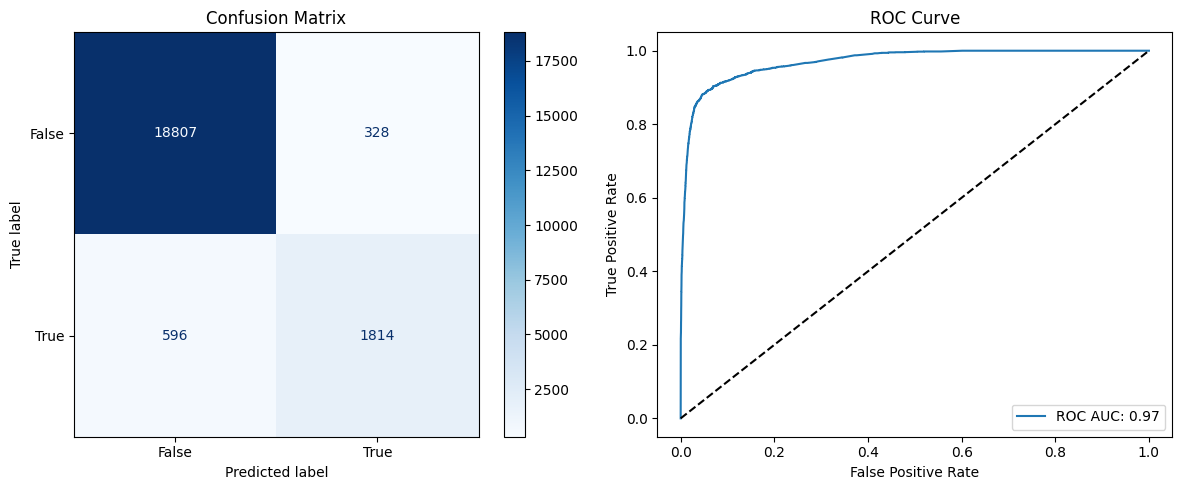

In [7]:
# Visualize Confusion Matrix and ROC Curve
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues', ax=axes[0])
axes[0].set_title("Confusion Matrix")
fpr, tpr, _ = roc_curve(y_test, y_prob)
axes[1].plot(fpr, tpr, label=f'ROC AUC: {roc_auc_score(y_test, y_prob):.2f}')
axes[1].plot([0, 1], [0, 1], 'k--')
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()
axes[1].set_title("ROC Curve")

plt.tight_layout()
plt.show()

In [8]:
# Visualize SHAP Feature Importance
X_train_transformed = model.named_steps['preprocessor'].transform(X_train) #.toarray()
X_test_transformed = model.named_steps['preprocessor'].transform(X_test) #.toarray()

explainer = shap.Explainer(model.named_steps['classifier'], X_train_transformed)
shap_values = explainer(X_test_transformed)
shap_values.feature_names = model.named_steps['preprocessor'].get_feature_names_out()

 99%|===================| 21391/21545 [01:23<00:00]       

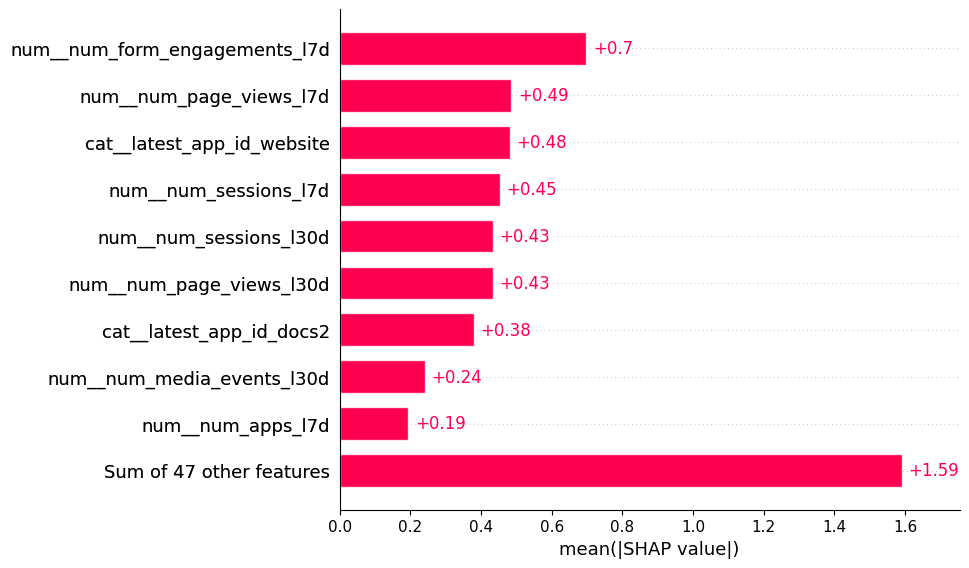

In [9]:
shap.plots.bar(shap_values)

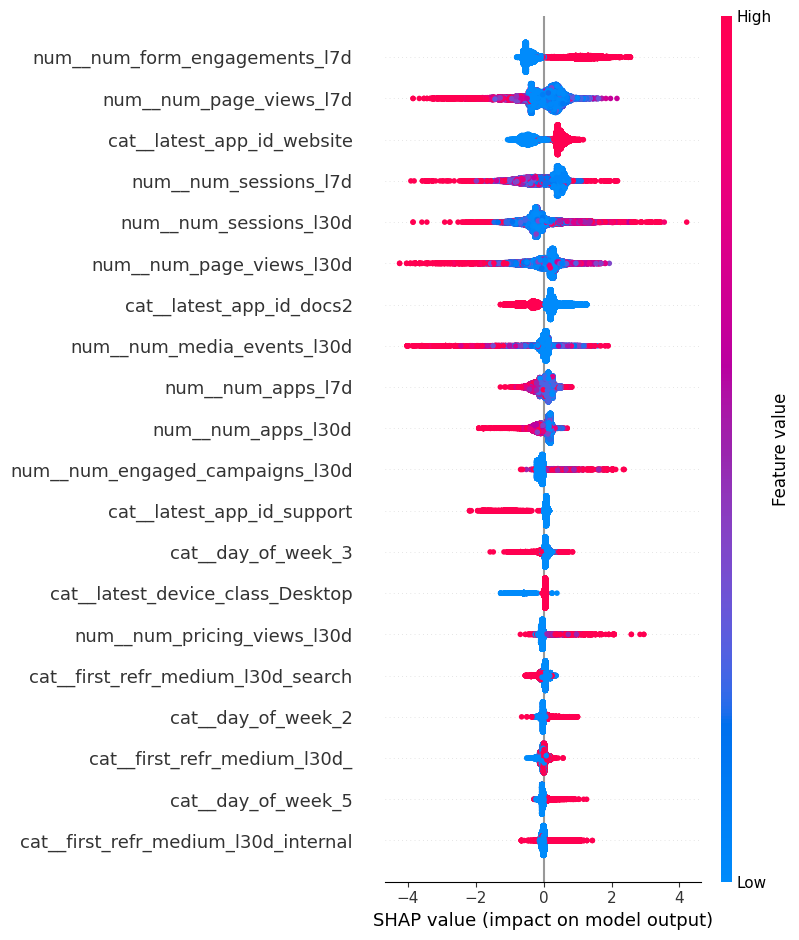

In [10]:
shap.summary_plot(shap_values, X_test_transformed)

## Part 3: _Data Engineer / MLOps Journey_ - Real-time scoring API Deployment

In this part we will:

1. Configure Signals API with relevant real-time features.
2. Create a simple backend API to serve predictions. The API will take `domain_userid` as an input, call Signals API to get real-time features, score the result and return it to the frontend.

In order for the API endpoint to work out of Colab we suggest using ngrok to make the API available globally under HTTPS.
This simplifies any future browser testing.

### Configure Signals API Real-Time Attributes

In [ ]:
!pip install snowplow-signals

In [ ]:
from snowplow_signals import Attribute, Criteria, Criterion, Event, View, user_entity
from datetime import timedelta

# Define Standard Events
sp_page_view = Event(vendor="com.snowplowanalytics.snowplow", name="page_view", version="1-0-0")
sp_page_ping = Event(vendor="com.snowplowanalytics.snowplow", name="page_ping", version="1-0-0")
sp_submit_form = Event(vendor="com.snowplowanalytics.snowplow", name="submit_form", version="1-0-0")
sp_focus_form = Event(vendor="com.snowplowanalytics.snowplow", name="focus_form", version="1-0-0")
sp_change_form = Event(vendor="com.snowplowanalytics.snowplow", name="change_form", version="1-0-0")
sp_media_events = Event(vendor="com.snowplowanalytics.snowplow.media")

l7d=timedelta(days=7)
l30d=timedelta(days=30)

# Attributes - Latest page_view behaviour
latest_app_id = Attribute(name="latest_app_id", type="string", events=[sp_page_view], aggregation="last", property="app_id")
latest_device_class = Attribute(name="latest_device_class", type="string", events=[sp_page_view], aggregation="last", property="contexts_nl_basjes_yauaa_context_1[0].deviceClass")

# # Attributes - Behaviour over the last 7d
num_sessions_l7d = Attribute(name="num_sessions_l7d", type="string_list", events=[sp_page_view], period=l7d, aggregation="unique_list", property="domain_sessionid") # We will convert this a count on our side
num_apps_l7d = Attribute(name="num_apps_l7d", type="string_list", events=[sp_page_view], period=l7d, aggregation="unique_list", property="app_id")
num_page_views_l7d = Attribute(name="num_page_views_l7d", type="int32", events=[sp_page_view], period=l7d, aggregation="counter")
num_page_pings_l7d = Attribute(name="num_page_pings_l7d", type="int32", events=[sp_page_ping], period=l7d, aggregation="counter")
num_pricing_views_l7d = Attribute(name="num_pricing_views_l7d", type="int32", events=[sp_page_view], period=l7d, aggregation="counter",
    criteria=Criteria(all=[Criterion(property="page_url", operator="like", value="%pricing%")]))
num_conversions_l7d = Attribute(name="num_conversions_l7d", type="int32", events=[sp_submit_form], period=l7d, aggregation="counter") # We will convert this to boolean as ">0"
num_form_engagements_l7d = Attribute(name="num_form_engagements_l7d", type="int32", events=[sp_focus_form, sp_change_form], period=l7d, aggregation="counter")

# # Attributes - Behaviour over the last 30d
num_sessions_l30d = Attribute(name="num_sessions_l30d", type="string_list", events=[sp_page_view], period=l30d, aggregation="unique_list", property="domain_sessionid")
num_apps_l30d = Attribute(name="num_apps_l30d", type="string_list", events=[sp_page_view], period=l30d, aggregation="unique_list", property="app_id")
num_page_views_l30d = Attribute(name="num_page_views_l30d", type="int32", events=[sp_page_view], period=l30d, aggregation="counter")
num_page_pings_l30d = Attribute(name="num_page_pings_l30d", type="int32", events=[sp_page_ping], period=l30d, aggregation="counter")
num_pricing_views_l30d = Attribute(name="num_pricing_views_l30d", type="int32", events=[sp_page_view], period=l30d, aggregation="counter",
    criteria=Criteria(all=[Criterion(property="page_url", operator="like", value="%pricing%")]))
num_conversions_l30d = Attribute(name="num_conversions_l30d", type="int32", events=[sp_submit_form], period=l30d, aggregation="counter")
num_media_events_l30d = Attribute(name="num_media_events_l30d", type="int32", events=[sp_media_events], period=l30d, aggregation="counter")
first_refr_medium_l30d = Attribute(name="first_refr_medium_l30d", type="string", events=[sp_page_view], period=l30d, aggregation="first", property="refr_medium")
first_mkt_medium_l30d = Attribute(name="first_mkt_medium_l30d", type="string", events=[sp_page_view], period=l30d, aggregation="first", property="mkt_medium")
num_engaged_campaigns_l30d = Attribute(name="num_engaged_campaigns_l30d", type="string_list", events=[sp_page_view], period=l30d, aggregation="unique_list", property="mkt_campaign")

# Wrap attributes into a view
user_attributes_view = View(
    name="demo_landing_page",
    version=1,
    entity=user_entity,
    attributes=[
        latest_app_id,
        latest_device_class,
        num_sessions_l7d,
        num_apps_l7d,
        num_page_views_l7d,
        num_page_pings_l7d,
        num_pricing_views_l7d,
        num_conversions_l7d,
        num_form_engagements_l7d,
        num_sessions_l30d,
        num_apps_l30d,
        num_page_views_l30d,
        num_page_pings_l30d,
        num_pricing_views_l30d,
        num_conversions_l30d,
        num_media_events_l30d,
        first_refr_medium_l30d,
        first_mkt_medium_l30d,
        num_engaged_campaigns_l30d,
    ],
)

In [18]:
# Apply view to the Signals API
from snowplow_signals import Signals
sp_signals = Signals(api_url=SIGNALS_API_ENDPOINT,
                     api_key=userdata.get('SP_API_KEY'),
                     api_key_id=userdata.get('SP_API_KEY_ID'),
                     org_id=userdata.get('SP_ORG_ID'))
applied = sp_signals.apply([user_attributes_view])
print(f"{len(applied)} objects applied")

1 objects applied


In [15]:
applied

[ViewOutput(name='demo_landing_page', version=1, entity=LinkEntity(name='user'), ttl=None, batch_source=None, online=True, description=None, tags=None, owner=None, fields=[], attributes=[AttributeOutput(name='latest_app_id', description=None, type='string', tags=None, events=[Event(name='page_view', vendor='com.snowplowanalytics.snowplow', version='1-0-0')], aggregation='last', property='app_id', criteria=None, period=None), AttributeOutput(name='latest_geo_country', description=None, type='string', tags=None, events=[Event(name='page_view', vendor='com.snowplowanalytics.snowplow', version='1-0-0')], aggregation='last', property='geo_country', criteria=None, period=None), AttributeOutput(name='latest_device_class', description=None, type='string', tags=None, events=[Event(name='page_view', vendor='com.snowplowanalytics.snowplow', version='1-0-0')], aggregation='last', property='contexts_nl_basjes_yauaa_context_1[0].deviceClass', criteria=None, period=None), AttributeOutput(name='num_se

In [ ]:
# Test view on the Signals API on the last one hour of data from the atomic events table
sp_signals_test = sp_signals.test(view=user_attributes_view, app_ids=["website"])
sp_signals_test

In [21]:
# Test view on the Signals API on the last one hour of data from the atomic events table
sp_signals_result = sp_signals.get_online_attributes(user_attributes_view, '1d14a66e-4e19-4a84-af89-19f25a7b4c11')
sp_signals_result

OnlineAttributesResponse(data={'domain_userid': ['1d14a66e-4e19-4a84-af89-19f25a7b4c11'], 'latest_device_class': ['Desktop'], 'num_apps_l7d': [['website']], 'first_mkt_medium_l30d': [''], 'latest_app_id': ['website'], 'num_page_pings_l30d': [1], 'num_sessions_l7d': [['1c6a8924-1690-4f92-a573-ee702c2e7365']], 'num_pricing_views_l7d': [0], 'num_engaged_campaigns_l30d': [[]], 'num_page_views_l7d': [1], 'num_conversions_l30d': [0], 'num_page_views_l30d': [1], 'num_pricing_views_l30d': [0], 'num_media_events_l30d': [0], 'num_apps_l30d': [['website']], 'num_sessions_l30d': [['1c6a8924-1690-4f92-a573-ee702c2e7365']], 'num_page_pings_l7d': [1], 'num_conversions_l7d': [0], 'first_refr_medium_l30d': [''], 'num_form_engagements_l7d': [0]})

### Create Model Serving API Endpoint

In [ ]:
!pip install fastapi nest-asyncio pyngrok uvicorn

In [ ]:
import joblib
import pandas as pd
from collections import defaultdict
from pydantic import BaseModel
from typing import Optional
from fastapi import FastAPI
from fastapi.middleware.cors import CORSMiddleware
import uvicorn
import datetime
from snowplow_signals import Signals, View

# Load model
model = joblib.load("xgb_model.joblib")
explainer = shap.Explainer(model.named_steps['classifier'])

# Connect Signals
sp_signals = Signals(api_url=SIGNALS_API_ENDPOINT,
                     api_key=userdata.get('SP_API_KEY'),
                     api_key_id=userdata.get('SP_API_KEY_ID'),
                     org_id=userdata.get('SP_ORG_ID'))
sp_view = sp_signals.get_view("demo_landing_page")

# Input schema
class InputData(BaseModel):
    domain_userid: str
    # ... add more input columns if needed

# API
app = FastAPI()
app.add_middleware(
    CORSMiddleware,
    allow_origins=['*'],
    allow_credentials=True,
    allow_methods=['*'],
    allow_headers=['*'],
)

def get_duid_values(duid: str):
    response = sp_signals.get_online_attributes(
        sp_view,
        duid
    )
    df = response.to_dataframe()

    # Add your own custom columns and filters
    get_len = lambda x: len(x) if hasattr(x, '__len__') else 0
    df['day_of_week'] = datetime.date.today().isoweekday()
    df[df.filter(like="num_").columns] = df.filter(like="num_").fillna(0)

    # Switch counter columns to booleans
    df['had_conversions_l7d'] = (df['num_conversions_l7d'] > 0).astype(int)
    df['had_conversions_l30d'] = (df['num_conversions_l30d'] > 0).astype(int)
    df = df.drop(columns=['num_conversions_l7d', 'num_conversions_l30d'])

    # Switch unique arrays to amounts
    df['num_sessions_l7d'] = df['num_sessions_l7d'].apply(get_len)
    df['num_apps_l7d'] = df['num_apps_l7d'].apply(get_len)
    df['num_sessions_l30d'] = df['num_sessions_l30d'].apply(get_len)
    df['num_apps_l30d'] = df['num_apps_l30d'].apply(get_len)
    df['num_engaged_campaigns_l30d'] = df['num_engaged_campaigns_l30d'].apply(get_len)

    # Reorder columns to follow the training order
    df = df.reindex(columns=x_columns, fill_value=0)
    return (df, response.to_dataframe())

def get_prediction_explanations(df, top_n=5):
    # calculate shap values
    df_transformed = model.named_steps['preprocessor'].transform(df) #.toarray()
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()
    df_transformed_df = pd.DataFrame(df_transformed, columns=feature_names)
    shap_values = explainer(df_transformed_df)
    feature_contributions = dict(zip(
        feature_names,
        shap_values.values[0]
    ))
    # group feature names: cat__feat_one_value1 -> feat_one
    grouped = defaultdict(float)
    for feat, val in feature_contributions.items():
        base = feat[5:].rsplit('_', 1)[0] if feat.startswith('cat__') else feat.split('__', 1)[1]
        grouped[base] += val
    sorted_grouped = dict(sorted(grouped.items(), key=lambda x: abs(x[1]), reverse=True))
    top_items = dict(list(sorted_grouped.items())[:top_n])
    sum_of_others = sum(sorted_grouped.values()) - sum(top_items.values())
    top_items["__sum_of_others"] = sum_of_others
    top_items = {k: float(v) for k, v in top_items.items()}
    return top_items

def get_predictions(df, explanations=None):
    prediction = float(model.predict_proba(df)[:, 1][0])
    if explanations is None:
        return prediction
    top_contributors = get_prediction_explanations(df, explanations)
    return (prediction, top_contributors)

@app.post("/predict")
def predict(data: InputData):
    input_dict = data.model_dump()

    # Get Signals data and prepare dataframe for scoring
    df, signals_response = get_duid_values(input_dict['domain_userid'])

    # Score dataframe using the trained model
    prediction, explanations = get_predictions(df, 5)

    # Return the result
    print(f"P: {round(prediction, 4)} - {input_dict}")
    return {
        "signals": signals_response.to_dict(orient='records')[0],
        "scoring_attributes": df.to_dict(orient='records')[0],
        "explanations": explanations,
        "score": prediction
    }

In [ ]:
# d, s = get_duid_values('1d14a66e-4e19-4a84-af89-19f25a7b4c11')
# p, e = get_predictions(d, 5)
# e

In [ ]:
# Let's make this endpoint available globally via ngrok
import nest_asyncio
from pyngrok import ngrok, conf
import uvicorn
from google.colab import userdata

conf.get_default().auth_token = userdata.get('NGROK_TOKEN')
ngrok_tunnel = ngrok.connect(8000)
print('Public URL:', ngrok_tunnel.public_url)
nest_asyncio.apply()
uvicorn.run(app, port=8000)

INFO:     Started server process [200]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


Public URL: https://4d89-34-74-18-191.ngrok-free.app
P: 0.0408 - {'domain_userid': '1d14a66e-4e19-4a84-af89-19f25a7b4c11'}
INFO:     45.12.27.163:0 - "POST /predict HTTP/1.1" 200 OK
P: 0.0408 - {'domain_userid': '1d14a66e-4e19-4a84-af89-19f25a7b4c11'}
INFO:     45.12.27.163:0 - "POST /predict HTTP/1.1" 200 OK


Now you can call the API using cURL or via JS from the website.


Verify via cURL:

```bash
curl -X POST "https://<REPLACE_WITH_YOUR_NGROK_URL>/predict" \
-H "Content-Type: application/json" \
-d '{"domain_userid": "b5c84e7e-a053-45dd-b4e8-347bbe002bbd"}'
```


Verify via JS in the browser console:

```js
// Let's call the API every 10s from the frontend
let api_url = "https://<REPLACE_WITH_YOUR_NGROK_URL>/predict";
let tracker_name = "sp";

setInterval(function () {
    snowplowTracker(function () {
        // get domain_userid
        var sp = this[tracker_name];
        var domainUserId = sp.getDomainUserId();
        
        // call the API
        fetch(api_url, {
            method: "POST",
            headers: { "Content-Type": "application/json" },
            body: JSON.stringify({ domain_userid: domainUserId })
        })
        .then(response => response.json())
        .then(result => {
            console.log("Prediction: ", domainUserId, " - ", result.score);

            // act on prediction
            if (result.score >= 0.9) console.log('Prospect is likely to convert!');
        })
        .catch(console.error);
    });
}, 10 * 1000);
```


The API response should look like this.
It will have signals-provided attributes, scoring features, prediction score, top5 prediction explanations.
Use `.score` field to get the prediction score for your decisions.

```json
{
  "signals": {
    "domain_userid": "1d14a66e-4e19-4a84-af89-19f25a7b4c11",
    "latest_device_class": "Desktop",
    "num_apps_l7d": [
      "website"
    ],
    "first_mkt_medium_l30d": "",
    "latest_app_id": "website",
    "num_page_pings_l30d": 1,
    "num_sessions_l7d": [
      "1c6a8924-1690-4f92-a573-ee702c2e7365"
    ],
    "num_pricing_views_l7d": 0,
    "num_engaged_campaigns_l30d": [],
    "num_page_views_l7d": 2,
    "latest_geo_country": "UA",
    "num_conversions_l30d": 0,
    "num_page_views_l30d": 2,
    "num_pricing_views_l30d": 0,
    "num_media_events_l30d": 0,
    "num_apps_l30d": [
      "website"
    ],
    "num_sessions_l30d": [
      "1c6a8924-1690-4f92-a573-ee702c2e7365"
    ],
    "num_page_pings_l7d": 1,
    "num_conversions_l7d": 0,
    "first_refr_medium_l30d": "",
    "num_form_engagements_l7d": 0
  },
  "scoring_attributes": {
    "latest_app_id": "website",
    "day_of_week": 2,
    "latest_device_class": "Desktop",
    "num_sessions_l7d": 1,
    "num_apps_l7d": 1,
    "num_page_views_l7d": 2,
    "num_page_pings_l7d": 1,
    "num_pricing_views_l7d": 0,
    "had_conversions_l7d": 0,
    "num_form_engagements_l7d": 0,
    "num_sessions_l30d": 1,
    "num_apps_l30d": 1,
    "num_page_views_l30d": 2,
    "num_page_pings_l30d": 1,
    "num_pricing_views_l30d": 0,
    "had_conversions_l30d": 0,
    "num_media_events_l30d": 0,
    "first_refr_medium_l30d": "",
    "first_mkt_medium_l30d": "",
    "num_engaged_campaigns_l30d": 0
  },
  "explanations": {
    "num_form_engagements_l7d": -1.3108587265014648,
    "latest_app_id": 0.4391634464263916,
    "num_sessions_l7d": 0.4115472435951233,
    "num_page_views_l7d": 0.3009951114654541,
    "num_page_views_l30d": -0.2526836097240448,
    "__sum_of_others": -0.33708104491233826
  },
  "score": 0.040799494832754135
}
```
